In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sn
import pandas as pd

In [2]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "purple"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  plt.savefig("../results/plots/{}.png".format(title), dpi=600)
  plt.show()

In [3]:
fname = "../data/datasets.5000a.layer=layer=6.pickle"
fname2 = "../data/datasets.5000t.layer=layer=6.pickle"

with open(fname, "rb") as f:
    data = pickle.load(f)

    
with open(fname2, "rb") as f:
    data_nonlex = pickle.load(f)

In [4]:
projs_path = "../data/type2P.layer=6.iters=32.classifier=svm.pickle"
with open(projs_path, "rb") as f:
    type2proj = pickle.load(f)
    
comps = projs_path.split(".")
layer = comps[-4]
iters = comps[-3]
print(layer, iters)

layer=6 iters=32


In [20]:
vecs, vecs_rowspace, labels = [],[], []
vecs_rowspace_nonlex = []
k = 300
type2vecs_rowspace = {}
type2vecs_rowspace_nonlex = {}

for type_pos in data.keys():
    
    P_rowspace = np.eye(768) - type2proj[type_pos]
    #P_rowspace = np.eye(768) - type2proj["prrc"]
    
    train_x, train_y = data[type_pos]["train"]
    train_x_nonlex, train_y_nonlex = data_nonlex[type_pos]["train"]
    
    mask = train_y != 0
    mask_nonlex = train_y_nonlex != 0
    
    relevant_x = train_x[mask]
    relevant_x_nonlex = train_x_nonlex[mask_nonlex]
    
    label = [type_pos] * k
    vecs.append(relevant_x[:k])
    vecs_rowspace.append((relevant_x.dot(P_rowspace))[:k])
    vecs_rowspace_nonlex.append(relevant_x_nonlex.dot(P_rowspace)[:k])
    
    type2vecs_rowspace[type_pos] = relevant_x.dot(P_rowspace)
    type2vecs_rowspace_nonlex[type_pos] = relevant_x_nonlex.dot(P_rowspace)
    
    labels.extend(label)
vecs = np.concatenate(vecs, axis = 0)
vecs_rowspace = np.concatenate(vecs_rowspace, axis = 0)
vecs_rowspace_nonlex = np.concatenate(vecs_rowspace_nonlex, axis = 0)
labels = np.array(labels)
print(vecs.shape, len(labels))

(1500, 768) 1500


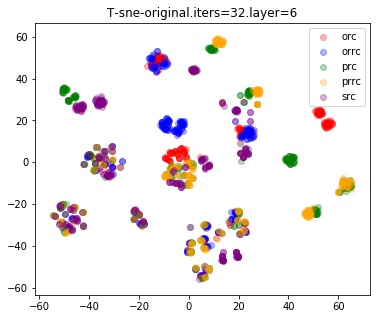

In [7]:
tsne(vecs, labels, "T-sne-original.{}.{}".format(iters, layer))

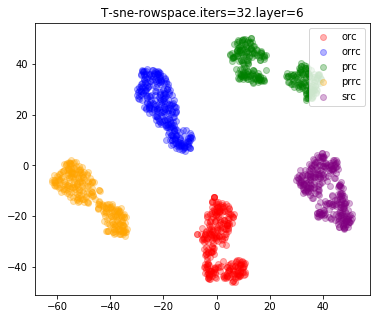

In [21]:
tsne(vecs_rowspace, labels, title = "T-sne-rowspace.{}.{}".format(iters, layer))

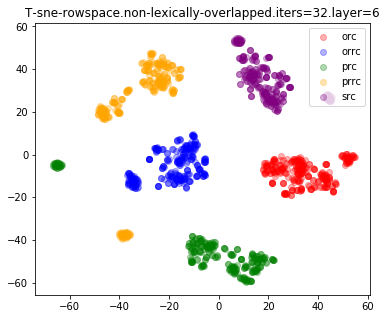

In [9]:
tsne(vecs_rowspace_nonlex, labels, title = "T-sne-rowspace.non-lexically-overlapped.{}.{}".format(iters, layer))

In [ ]:
sims = np.zeros((5,5))
type2ind = {d:i for i,d in enumerate(type2vecs_rowspace.keys())}
ind2type = {i:d for d,i in type2ind.items()}

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for key, vecs in type2vecs_rowspace.items():
    for key2, vecs2 in type2vecs_rowspace_nonlex.items():
        #mean1, mean2 = np.mean(vecs, axis = 0), np.mean(vecs2, axis = 0)
        #mean1_normed, mean2_normed = mean1 / np.linalg.norm(mean1), mean2 / np.linalg.norm(mean2)
        
        sims2 = cosine_similarity(vecs, vecs2)
        print(sims2.shape)
        vecs_normed = vecs / np.linalg.norm(vecs, axis = 1, keepdims = True)
        vecs2_normed = vecs2 / np.linalg.norm(vecs2, axis = 1, keepdims = True)
        
        sims[type2ind[key], type2ind[key2]] = np.mean(sims2) #mean1_normed.dot(mean2_normed.T)

In [ ]:
sims

In [ ]:
labels = [ind2type[i] for i in range(len(ind2type))]


In [ ]:
def plot(labels, results, layer, classifier,iters):

    df_cm = pd.DataFrame(results, index = labels,
                  columns = labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("Cosine similarity in RC subspace between various RCs. {}. classifier: {}. {}".format(layer, classifier, iters))
    #plt.show()
    plt.savefig("../results/plots/rowspace-similarity.pairs:{}.classifier:{}.{}.png".format(layer, classifier, iters), dpi=300)    


In [ ]:
plot(labels, sims, layer, "svm", iters)